the overall priority system should be something like:
get nortons.
if fewer than 5 nortons, get sbns
if fewer than 5 sbsn, get strict parens
if fewer than 5 strict parens, get loose parens

#that requires an update to the classes to store strict and loose parens collection groups.


return all citations. 

In [1]:
from single_file_processing_functions import convert_pdf_to_no_ws_txt as pdf_converter

In [206]:
strawson_chapter = pdf_converter('pdfs/SCHIHA-3.2.pdf')

Created No WS txt at txts/SCHIHA-3.2.txt


In [2]:
from single_file_processing_classes import *

In [3]:
import re

In [6]:
new_norton = """
                        Abs(tract)*\.*§*\d+([-–—,]\d{1,2})*|
                        App(endix)*\.*§*\d+([-–—,]\d{1,2})*|
                        ((I{1,3}|[123])\.)(([i]{1,3}|IV|[I]{1,3}|[1-4])\.)(\d{1,2})(\.[1-9]\d{0,2}([-–—]\d{1,2}){0,1}){0,1}""", re.X

In [4]:
class Paper:
    def __init__(self, txt_file_name):
        self.name = txt_file_name
        self.nortonCites = []
        self.sbnCites = []
        self.rawParenthesesCapture = []
        self.tCites = []
        self.pageNumCites = []
        self.rawNortonScore = {}
        self.rawSbnScore = {}
        self.rawTScore = {}
        self.rawPageNumScore = {}
        self.a_l_p = {}
        self.a_w_p = {}
        self.s_l_p = {}
        self.s_w_p = {}
        self.totalStrictCites = 0
        self.totalAggressiveCites = 0
        self.s_w_c = {}
        self.s_l_c = {}
        self.a_w_c = {}
        self.a_l_c = {}
        self.biblio = {}
        

    def NortonSearch(self):
        citationCounter = 0 #citation counter to be used in numbering citations
        #create the citation search object
        #search pattern is
##        Capture Abstract cites with optional dash additions
##        Capture Appendix cites with optional dash additions
##        Capture Main body cites as follows:
##            Book. (capture both roman and arabic numeral versions)
##            Part. (capture both roman (capitalized and not) and arabic numerals)
##            Section (I left of the '.' here to be able to capture citations that are only Book.Part.Section with no paragraph citation)
##            optional .Paragraph(s with optional dash separator for a range of paragraphs
        nortonPattern = re.compile("""  Abs\.*(tract)*§*\d+([-–—,]\d{1,2})*|
                                        App\.*(endix)*§*\d+([-–—,]\d{1,2})*|
                                        ((I{1,3}|[123]))
                                        (\.([i]{1,3}|IV|[I]{1,3}|[1-4]))
                                        (\.\d{1,2})
                                        (
                                            (\.)(?=\d{1,2})
                                            \d{1,2}(?!\d)
                                            ([-–—,]\d{1,2}(?!([\d]|(\.\d))))*
                                        )*""", flags=re.X|re.I)        
        #make the text of the paper accessible and generate the match objects
        text_name = 'txts/'+self.name+'.txt'
        paper_to_search = open(text_name, "r")
        text_to_search = paper_to_search.read().strip().replace(' ','')
        paper_to_search.close()
        matchObjects = nortonPattern.finditer(text_to_search)
        #create a citation for each match object
        for match in matchObjects:
            citationCounter +=1
            citationObject = Citation(self.name, citationCounter, match.group())
            citationObject.startPoint = match.start()
            citationObject.endPoint = match.end()
            citationObject.search_term = match.re
            self.nortonCites.append(citationObject)
        if len(self.nortonCites) == 0:
            pass

    def SbnSearch(self):
        citationCounter = 0 #citation counter to be used in numbering citations
        #create the citation search object
##        the search pattern this time is to start with SBN
##        then cover page numbers (I got rid of 0 as a starting point because a file happened to have a weird SBN0 followed by a long string of numbers
##        next I have an optional dash and comma separator that can be repeated to capture the multiple pages and ranges that get cited
##        this will require some cleaning because sometimes you get a random 'i' following the comma
        sbnPattern = re.compile(""" (?<!I)
                                    (SBN)
                                    ([1-9]\d+|[xvi]+|[XVI]+)
                                    ([-–—,](\d+|[xvi]+|[XVI]+))*""", re.X)
        #make the text of the paper accessible and generate the match objects
        text_name = 'txts/'+self.name+'.txt'
        paper_to_search = open(text_name, "r")
        text_to_search = paper_to_search.read().strip().replace(' ','')
        paper_to_search.close()
        matchObjects = sbnPattern.finditer(text_to_search)
        #create a citation for each match object
        for match in matchObjects:
            citationCounter +=1
            citationObject = Citation(self.name, citationCounter, match.group())
            citationObject.startPoint = match.start()
            citationObject.endPoint = match.end()
            citationObject.search_term = match.re
            self.sbnCites.append(citationObject)
        if len(self.sbnCites) == 0:
            pass

    def parenthesesCapture(self):
        citationCounter = 0 #citation counter to be used in numbering citations
        #create the citation search object
        #This idea behind this search string is to get anything in parentheses with the following structure:
            #First, it can optionally start with either a 'T', 'THN', 'Treatise', or 'Hume'
            #Second, there can be a run of some intervening text but not a close parens or any numbers
            #Third, we get a page number citation with an optional p, p., or pp.
            #fourth, we get up to a three digit page number or range of up to 3 digit page numbers in either
                #roman or arabic numerals
            #The only thing I haven't figured out how to capture yet is a brief comment that appears in a few
            #cases where the authro says something like, 'my emphases' or 'italics mine'. I think that might
            #require a different search with a more restrictive start to the parentheses
        pattern = re.compile('\((T|THN|Treatise|Hume)*([A-Z]|[a-z]|[,.])*(p*\.{0,1}(\d{1,3}|[xvi]+|[XVI]+)([-–—,](\d+|[xvi]{1,5}|[XVI]{1,5}))*)\)')
        #make the text of the paper accessible and generate the match objects
        text_name = 'txts/'+self.name+'.txt'
        paper_to_search = open(text_name, "r")
        text_to_search = paper_to_search.read().strip().replace(' ','')
        paper_to_search.close()
        matchObjects = pattern.finditer(text_to_search)
        #create a citation for each match object
        for match in matchObjects:
            citationCounter +=1
            citationObject = Citation(self.name, citationCounter, match.group())
            citationObject.startPoint = match.start()
            citationObject.endPoint = match.end()
            citationObject.search_term = match.re
            self.rawParenthesesCapture.append(citationObject)
        if len(self.rawParenthesesCapture) == 0:
            pass
        
    
    def a_l_p_CSV(self):
        csv_file = open('csvs/'+self.name[5:-4]+'-a-l-p.csv', 'w')
        csv_writer = csv.writer(csv_file)
        for pair in self.a_l_p.items():
            csv_writer.writerow(pair)
    
    def a_w_p_CSV(self):
        csv_file = open('csvs/'+self.name[5:-4]+'-a-w-p.csv', 'w')
        csv_writer = csv.writer(csv_file)
        for pair in self.a_w_p.items():
            csv_writer.writerow(pair)
    
    def s_l_p_CSV(self):
        csv_file = open('csvs/'+self.name[5:-4]+'-s-l-p.csv', 'w')
        csv_writer = csv.writer(csv_file)
        for pair in self.s_l_p.items():
            csv_writer.writerow(pair)
    
    def s_w_p_CSV(self):
        csv_file = open('csvs/'+self.name[5:-4]+'-s-w-p.csv', 'w')
        csv_writer = csv.writer(csv_file)
        for pair in self.s_w_p.items():
            csv_writer.writerow(pair)
    
    def a_l_c_CSV(self):
        csv_file = open('csvs/'+self.name[5:-4]+'-a-l-c.csv', 'w')
        csv_writer = csv.writer(csv_file)
        for pair in self.a_l_c.items():
            csv_writer.writerow(pair)
    
    def a_w_c_CSV(self):
        csv_file = open('csvs/'+self.name[5:-4]+'-a-w-c.csv', 'w')
        csv_writer = csv.writer(csv_file)
        for pair in self.a_w_c.items():
            csv_writer.writerow(pair)
    
    def s_l_c_CSV(self):
        csv_file = open('csvs/'+self.name[5:-4]+'-s-l-c.csv', 'w')
        csv_writer = csv.writer(csv_file)
        for pair in self.s_l_c.items():
            csv_writer.writerow(pair)
    
    def s_w_c_CSV(self):
        csv_file = open('csvs/'+self.name[5:-4]+'-s-w-c.csv', 'w')
        csv_writer = csv.writer(csv_file)
        for pair in self.s_w_c.items():
            csv_writer.writerow(pair)
    
    def csvScoreDump(self):
        self.a_l_p_CSV()
        self.a_w_p_CSV()
        self.s_l_p_CSV()
        self.s_w_p_CSV()
        self.a_l_c_CSV()
        self.a_w_c_CSV()
        self.s_l_c_CSV()
        self.s_w_c_CSV()
        print('csvs dumped')


In [5]:
import re
from master_function_list import abstractCleaner, dotAppAdder

In [6]:
from master_function_list import ultimateParser as uP

Today, then, I've cleaned up a few of the new PDF files—Thiel book, Strawson book, two articles from Strawson and Noonan in the same companion book, the MacIntyre file downloaded May 22, rocknack book, kail chapter from book, new scherwain article...basically all the new pdfs i've acquired. I need to go back to double check some previous files to see whether they were processing from pd correctly

I've also added the ability to get the § sign parsed properly (this is already in the master function list.


I've also fixed some of the search strings in the class objects.

i still need to add teh more and less aggressive search options to the class definitions

Another search idea is to look for parentheses that start with 'Hume' and have a three digit page number in them, but are not four digit nubmers. That would capture some more citations than I'm getting now and would be very safe. So, inside a parentheses, the parentheses starts with hume and is a 1-3 digit number. Here's a regex to get 1-3 digit numbers only: '(?<!\d)\d{1,3}(?!\d)'. So the safest are Parens that start with Hume or Treatise or T followed by a page number, then we get parens that start with Hume or Treatise and have an up to 3 digit number inside the parentheses. 

In [7]:
def processPaper(paper_obj):
    #this function take a paper object in and will fill the search lists with citations
    #First, conduct the searches
    paper_obj.NortonSearch()
    paper_obj.SbnSearch()
    paper_obj.parenthesesCapture()
    
    #second, set the easy .cleanedCitations
    for cite in paper_obj.nortonCites:
        cite.cleanedCitation = cite.rawCitationText
    for cite in paper_obj.sbnCites:
        cite.cleanedCitation = cite.rawCitationText[3:]
    
    #third, sort the parentheses
    #in the sorting, we'll do a first pass to get the citations that start with T or Hume or THN or Treatise:
    strict_check = re.compile(r'(Hume|Treatise|THN|T)(([, \-\–\—p\.]*)((?<!\d)\d{1,3}(?!\d)))+', re.I)
    num_check = re.compile(r'(([, \-\–\—p\.]*)((?<!\d)\d{1,3}(?!\d)))+', re.I)
    for cite in paper_obj.rawParenthesesCapture:
        #make the strict check:
        #I start it at the first character to ignore the open parens that
        if strict_check.match(cite.rawCitationText[1:]) != None:
            if num_check.search(cite.rawCitationText) != None:
                num_text = num_check.search(cite.rawCitationText).group().replace(' ', '')
                #remove 'p', 'P', '.' from the nubmers
                num_text = num_text.replace('p','')
                num_text = num_text.replace('P','')
                num_text = num_text.replace('.','')
                #set the cleanedCitation to the num_text
                cite.cleanedCitation = num_text
                #add the cite to the tCites
                paper_obj.tCites.append(cite)
        else:
            if num_check.search(cite.rawCitationText) != None:
                num_text = num_check.search(cite.rawCitationText).group().replace(' ', '')
                #remove 'p', 'P', '.' from the nubmers
                num_text = num_text.replace('p','')
                num_text = num_text.replace('P','')
                num_text = num_text.replace('.','')
                #set the cleanedCitation to the num_text
                cite.cleanedCitation = num_text
                #add the cite to pageNumCites, if it's more than one digit
                #because otherwise we catch too much argument numbering use
                #of parentheses:
                if len(num_text) > 1:
                    paper_obj.pageNumCites.append(cite)

    print (paper_obj.name, 'processed')

In [8]:
strict_check = re.compile(r'(Hume|Treatise|THN|T)(([, \-\–\—p\.]*)((?<!\d)\d{1,3}(?!\d)))+', re.I)
test_text = '(Hume, p.25 - pp.300 )'
print(strict_check.search(test_text).group())
num_check = re.compile(r'((?<!\d)\d{1,3}(?!\d))(([, \-\–\—p\.]*)((?<!\d)\d{1,3}(?!\d)))*', re.I)
print(num_check.search(test_text).group())
print(num_check.search(test_text).group().replace(' ', '').replace('p','').replace('P','').replace('.',''))


Hume, p.25 - pp.300
25 - pp.300
25-300


In [9]:
aggressive_check = re.compile(r'(([, \-\–\—p\.]*)((?<!\d)\d{1,3}(?!\d)))+', re.I)
aggressive_check.search(test_text).group()

', p.25 - pp.300'

So, What I have now I can take in a text file and populate all of .cleanedCitation fields in every citation type. Next, I want to come up with a smarter score generator. 

The way the score generator will work is:
1. Create a score card dictionary
2. Calculate the Norton scores for each norton cite
3. If there are under 5 norton citations, go get the SBNs
4. If there are under 5 SBNs go get the strict Ts
5. If there are under 5 strict Ts, go get all the parens.

In [8]:
def chapterScores(para_scores):
    #this function takes in a dictionary score sheet for paragraph scores
    #and returns a dictionary score sheet for chapter scores
    chapter_scores = {}
    chapter_pattern = re.compile(r'(Abs)|(App\.)|(0)|(\d\.\d\.\d{1,2})')
    for para in para_scores.keys():
        chapter = chapter_pattern.match(para).group()
        if chapter not in chapter_scores.keys():
            chapter_scores[chapter] = 0
        chapter_scores[chapter] += para_scores[para]
    return chapter_scores



def citesToScores(cite_collection):
    #this function takes in a list of cites as you'd have in a paper object that's been processed
    #and returns a dictionary object with a count of total successful cites that were scored
    #and a scoresheet dictionary at the paragraph level
    out_sheet = {}
    successful_cites = 0
    for para in treatise_paragraph_list:
        out_sheet[para] = 0
    for cite in cite_collection:
        try:
            for pair in uP(cite.cleanedCitation):
                out_sheet[pair[0]] += pair[1]
            successful_cites += 1
        except Exception as e:
            print(cite.cleanedCitation, 'generated an error while scoring:', e)
    
    do = {}
    do['score_sheet'] = out_sheet
    do['total_cites'] = successful_cites
            
    return do

def relativeScoreCalc(score_dict):
    #this function calculates a score sheet relative to the paper object that is processed
    #ie how what percentage of the article's total cites go to a particular paragraph
    #get the total number of points awarded in the score_dict
    total_points = 0
    for entry in score_dict.keys():
        total_points += score_dict[entry]

    if total_points == 0:
        return score_dict
    
    else:
        #create the blank relative sheet
        relative_sheet = {}
        for para in treatise_paragraph_list:
            relative_sheet[para] = 0
        #fill in the blank relative sheet
        for para in relative_sheet.keys():
            relative_sheet[para] = 100 * score_dict[para]/total_points
        
        return relative_sheet
      

def paperScoreSetter(paper_obj):
    paper_obj.rawNortonScore = citesToScores(paper_obj.nortonCites)['score_sheet']
    paper_obj.rawSbnScore = citesToScores(paper_obj.sbnCites)['score_sheet']
    paper_obj.rawTScore = citesToScores(paper_obj.tCites)['score_sheet']
    paper_obj.rawPageNumScore = citesToScores(paper_obj.pageNumCites)['score_sheet']
    
    if len(paper_obj.nortonCites) > 5:
        paper_obj.s_w_p = paper_obj.rawNortonScore
        paper_obj.totalStrictCites = citesToScores(paper_obj.nortonCites)['total_cites']
         
    else:
        if len(paper_obj.sbnCites) > 5:
            strict_cites = paper_obj.nortonCites + paper_obj.sbnCites
            paper_obj.s_w_p = citesToScores(strict_cites)['score_sheet']
            paper_obj.totalStrictCites = citesToScores(strict_cites)['total_cites']
        else:
            strict_cites = paper_obj.nortonCites + paper_obj.sbnCites + paper_obj.tCites
            paper_obj.s_w_p = citesToScores(strict_cites)['score_sheet']
            paper_obj.totalStrictCites = citesToScores(strict_cites)['total_cites']

    agg_cites = paper_obj.nortonCites + paper_obj.sbnCites + paper_obj.tCites + paper_obj.pageNumCites
    paper_obj.totalAggressiveCites = citesToScores(agg_cites)['total_cites']
    paper_obj.a_w_p = citesToScores(agg_cites)['score_sheet']
    
    paper_obj.s_l_p = relativeScoreCalc(paper_obj.s_w_p)
    paper_obj.a_l_p = relativeScoreCalc(paper_obj.a_w_p)
    
    paper_obj.s_w_c = chapterScores(paper_obj.s_w_p)
    paper_obj.s_l_c = chapterScores(paper_obj.s_l_p) 
    paper_obj.a_w_c = chapterScores(paper_obj.a_w_p)
    paper_obj.a_l_c = chapterScores(paper_obj.a_l_p)
    
    print('finished setting scores for', paper_obj.name)

So, in addition to the previous steps forward I have now:
- updated the Paper Class ot have the right attributes
- written a function to set the raw and relative score sheets to distinguish smart and relative
- created the relevant homes for citations so that each type of search has its own citations and score sheets.
- can dump all scores into csvs.

What I need to work on now:
- I can create paper objects based on a CSV that's an output from the PhilPapers data base
- For those paper objects, I can process them to get a set of strict cites and aggressive cites, including a total count of successfully processed citations. I also have each set of citations that's attached to each of my four citation patterns (norton, sbn, t, and appropriate length page number)
- The next step will be to create to and from dictionary functions so that I can move back and forth between database stored objects and a website.
- i want to be able to generate on deman comparisons for relative scores, strict and aggressive, while also controlling for how many successive cites for each
- i also need to go back through the existing txt files to make sure I don't have too many (cid:xxx) poluted files

In [16]:
test_paper.csvScoreDump()

I also need to use the base here to update the main files.

I should try to run everything into a full single-file processor that will read a text, create all the different scores, and output the csvs.

As of the end of Friday, I updated some of the search parameters, added another two papers and started compiling chapters as they come in from ILL for Penelhum's Themes from Hume book;

still need the to and from dictionary functions to facilitate writing and reading from the gcloud database

also need to process all the docs with the new smart processor and then start getting the comparasion sets up to date.

Now let's work on a Chapter Conversion function that will work by adding up the citations from a score sheet to yield chapter scores.

In [17]:
chapter_pattern = re.compile(r'(Abs)|(App\.)|(0)|(\d\.\d\.\d{1,2})')
test_dict = second_test.relativeStrictScore
test_ch_dict = {}
for para in test_dict.keys():
    chap_pat = chapter_pattern.match(para).group()
    if chap_pat not in test_ch_dict.keys():
        test_ch_dict[chap_pat] = 0
    test_ch_dict[chap_pat] += test_dict[para]

relative_dict_total = 0
for para in test_dict.keys():
    relative_dict_total += test_dict[para]
print('the total input dict scores add to', str(relative_dict_total))

chap_total = 0
for chap in test_ch_dict.keys():
    chap_total += test_ch_dict[chap]
print('the total chapter dict scores add to', str(chap_total))

for chap in test_ch_dict.keys():
    print(chap, test_ch_dict[chap])

NameError: name 'second_test' is not defined

In [9]:
#Chapters: Appendix, Abstract, Book.Section.Chapter
#The way to do this is to start with any dictionary score sheet as input and return a chapter score sheet
#So, you put a paragraph based score sheet dictionary in and get out a chapter based score sheet


def chapterScores(para_scores):
    chapter_scores = {}
    chapter_pattern = re.compile(r'(Abs)|(App\.)|(0)|(\d\.\d\.\d{1,2})')
    for para in para_scores.keys():
        chapter = chapter_pattern.match(para).group()
        if chapter not in chapter_scores.keys():
            chapter_scores[chapter] = 0
        chapter_scores[chapter] += para_scores[para]
    return chapter_scores

In [19]:
for chapter in chapterScores(second_test.relativeStrictScore).keys():
    print(chapter, chapterScores(second_test.relativeStrictScore)[chapter])

NameError: name 'second_test' is not defined

Now that the chapter based score calculator is integrated we can update the Paper objects with Chapter based scores. Maybe in terms of the built in scores, I'll just attach this to aggressive and strict raw and relative dictionaries as attributes of the Paper object. That will then let us do chapter and paragraph based similarity comparisons.

In [20]:
total_counter = 0
for key in third_paper.strictRelativeChapterScore.keys():
    if third_paper.strictRelativeChapterScore[key] > 0:
        total_counter += third_paper.strictRelativeChapterScore[key]
        print(key, third_paper.strictRelativeChapterScore[key])
print(total_counter)

NameError: name 'third_paper' is not defined

In [71]:
third_paper.rawStrictScore['0.1']

0

In [12]:
import os
#make master score list
master_strict_para_list = {}
for para in treatise_paragraph_list:
    master_strict_para_list[para] = 0 
    
master_strict_chap_list = chapterScores(master_strict_para_list)

txt_dir = os.listdir('txts')

In [13]:
for filename in txt_dir:
    if 'txt' in filename:
        print('working on', filename)
        paper = newPaper('txts/'+filename)
        processPaper(paper)
        paperScoreSetter(paper)
        for para in master_strict_para_list.keys():
            master_strict_para_list[para] += paper.rawStrictScore[para]
        for chapter in master_strict_chap_list.keys():
            master_strict_chap_list[chapter] += paper.strictRawChapterScore[chapter]
        if paper.totalStrictCites < 1:
            print(filename, ": ", str(paper.totalStrictCites),file=zero_counter)
        print('done with', filename)
zero_counter.close()

working on 1398236.txt
txts/1398236.txt processed
finished setting scores for txts/1398236.txt


AttributeError: 'newPaper' object has no attribute 'rawStrictScore'

In [23]:
total_cites = 0
for para in master_strict_para_list:
    if master_strict_para_list[para] > 0:
        print(para, master_strict_para_list[para])
        total_cites += master_strict_para_list[para]
print(total_cites)        

1.1.1.1 8.702
1.1.1.2 4.202
1.1.1.3 0.202
1.1.1.4 0.077
1.1.1.5 0.139
1.1.1.6 0.139
1.1.1.7 5.138999999999999
1.1.1.8 8.305
1.1.1.9 0.743
1.1.1.10 2.243
1.1.1.11 12.41
1.1.1.12 3.41
1.1.1.1n2 0.202
1.1.2.1 10.333
1.1.3.1 1.0
1.1.3.4 3.583
1.1.4.1 24.901999999999997
1.1.4.2 6.819
1.1.4.3 3.8609999999999998
1.1.4.4 2.4719999999999995
1.1.4.5 2.4719999999999995
1.1.4.6 18.028
1.1.4.7 2.4859999999999998
1.1.5.1 2.084
1.1.5.2 1.028
1.1.5.3 1.5280000000000002
1.1.5.4 1.528
1.1.5.5 0.528
1.1.5.6 1.612
1.1.5.7 0.5840000000000001
1.1.5.8 2.584
1.1.5.9 0.5840000000000001
1.1.5.10 0.5840000000000001
1.1.6.1 4.75
1.1.6.2 1.666
1.1.6.3 2.0300000000000002
1.1.7.1 1.081
1.1.7.2 0.22099999999999997
1.1.7.3 6.220999999999999
1.1.7.4 0.158
1.1.7.5 0.158
1.1.7.6 1.721
1.1.7.7 5.482
1.1.7.8 0.419
1.1.7.9 0.45
1.1.7.10 0.40800000000000003
1.1.7.11 2.158
1.1.7.12 0.189
1.1.7.13 0.158
1.1.7.14 0.158
1.1.7.15 6.623
1.1.7.16 0.092
1.1.7.17 1.592
1.1.7.18 1.55
1.1.7.1n4 0.081
1.1.7.7n5 2.05
1.2.1.1 0.9
1.2.1.2 

2.2.8.4n65 0.048
2.2.9.5 0.25
2.2.9.6 0.25
2.2.9.7 0.25
2.2.9.8 0.25
2.2.9.13 1.0
2.2.10.1 0.21
2.2.10.2 0.21
2.2.10.3 0.21
2.2.10.4 1.2100000000000002
2.2.10.5 0.21
2.2.10.6 0.21
2.2.10.7 0.21
2.2.10.8 1.2100000000000002
2.2.10.9 1.2100000000000002
2.2.10.10 0.21
2.2.11.1 0.21
2.2.11.2 0.21
2.2.11.3 0.21
2.2.11.4 0.21
2.2.11.5 0.21
2.2.11.6 1.21
2.2.12.1 0.21
2.2.12.2 0.21
2.2.12.3 0.21
2.2.12.4 0.21
2.2.12.5 0.21
2.2.12.6 0.21
2.2.12.7 0.21
2.2.12.8 0.21
2.3.1.1 0.531
2.3.1.2 1.5310000000000001
2.3.1.3 0.531
2.3.1.4 2.198
2.3.1.5 0.198
2.3.1.6 0.198
2.3.1.7 0.198
2.3.1.8 0.531
2.3.1.9 0.531
2.3.1.10 1.864
2.3.1.11 0.531
2.3.1.12 0.531
2.3.1.13 0.198
2.3.1.14 0.198
2.3.1.15 0.198
2.3.1.16 1.198
2.3.1.17 0.198
2.3.1.18 0.198
2.3.2.1 0.75
2.3.2.2 1.75
2.3.2.3 0.25
2.3.2.4 3.25
2.3.2.5 1.25
2.3.2.6 0.75
2.3.2.7 0.75
2.3.2.8 0.25
2.3.3.1 0.6
2.3.3.2 0.6
2.3.3.3 1.1
2.3.3.4 1.1
2.3.3.5 2.1
2.3.3.6 0.1
2.3.3.7 2.1
2.3.3.8 0.1
2.3.3.9 0.1
2.3.3.10 0.1
2.3.6.10 1.0
2.3.7.1 6.0
2.3.7.2 1.0
2.3

In [230]:
test_chap = chapterScores(master_strict_para_list)
total_cites = 0
for chap in test_chap.keys():
    if test_chap[chap] > 0:
        print(chap, test_chap[chap])
        total_cites += test_chap[chap]
print(total_cites)        

1.1.1 45.913
1.1.2 10.333
1.1.3 4.583
1.1.4 61.03999999999999
1.1.5 12.644
1.1.6 8.446000000000002
1.1.7 30.970000000000006
1.2.1 6.9990000000000006
1.2.2 6.987999999999998
1.2.3 18.054999999999996
1.2.4 15.499
1.2.5 21.979999999999997
1.2.6 23.002
1.3.1 6.667999999999999
1.3.2 35.02899999999999
1.3.3 2.988000000000001
1.3.4 0.778
1.3.5 4.221
1.3.6 15.993000000000004
1.3.7 4.5
1.3.8 10.514000000000001
1.3.9 6.0
1.3.10 2.2519999999999993
1.3.11 0.27299999999999996
1.3.12 2.545999999999999
1.3.13 4.473000000000001
1.3.14 131.169
1.3.15 10.522
1.3.16 7.186999999999999
1.4.1 6.333
1.4.2 307.18000000000006
1.4.3 56.516000000000005
1.4.4 18.957
1.4.5 182.7550000000001
1.4.6 801.638
1.4.7 50.34600000000001
2.1.1 9.477
2.1.2 45.972
2.1.3 8.001
2.1.4 6.0
2.1.5 23.006999999999998
2.1.6 15.002000000000002
2.1.7 8.999
2.1.8 9.996999999999998
2.1.9 7.324999999999996
2.1.10 7.772999999999999
2.1.11 45.0
2.1.12 3.186999999999999
2.2.1 12.390000000000004
2.2.2 22.468999999999998
2.2.3 3.99899999999999

In [10]:
import pandas as pd

In [28]:
pdata = pd.DataFrame.from_dict(master_strict_para_list, orient='index', columns=['score'])
pdata['score'].sum()

2744.743

In [15]:
import matplotlib as plt

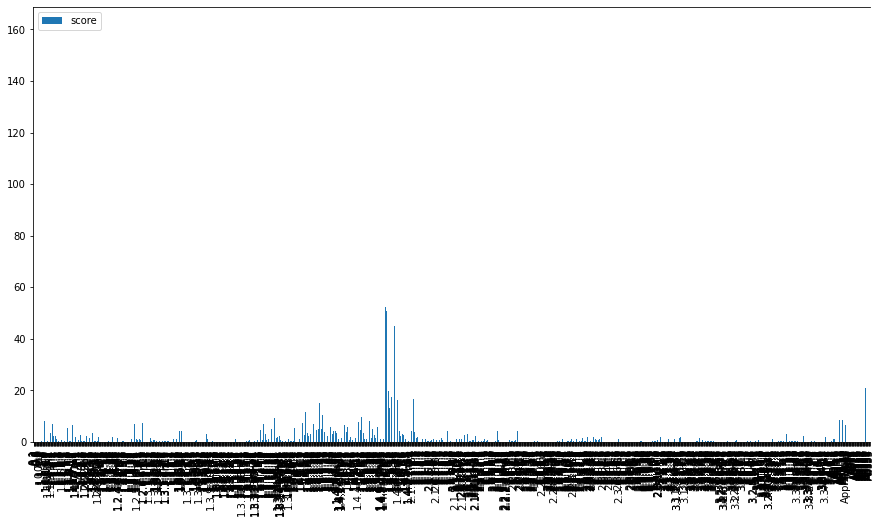

In [32]:
pdata.plot.bar(figsize=(15,8)).spines['right'].set_color('none')

In [27]:
cdata = pd.DataFrame.from_dict(master_strict_chap_list, orient='index', columns=['score'])
cdata['score'].sum()

2744.743

matplotlib.axes._subplots.AxesSubplot

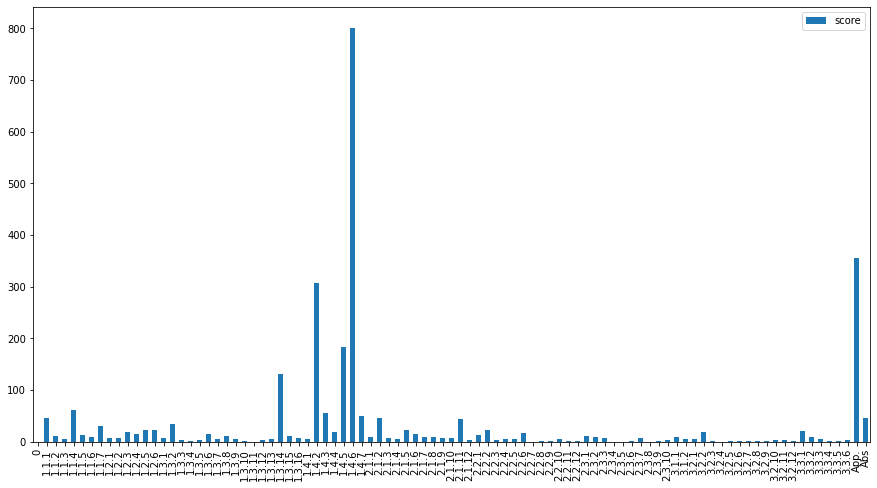

In [29]:
type(cdata.plot.bar(figsize=(15,8)))

In [34]:
pdata['score'].sort_values()[-10:]

1.4.6.18     44.887
1.4.6.5      50.735
1.4.6.2      52.049
1.4.6.3      52.164
1.4.6.19     62.613
1.4.6.16     62.615
App.21       63.988
1.4.6.4      65.718
1.4.6.6      69.623
App.20      160.638
Name: score, dtype: float64

In [33]:
cdata['score'].sort_values()[-10:]

1.1.1      45.913
2.1.2      45.972
1.4.7      50.346
1.4.3      56.516
1.1.4      61.040
1.3.14    131.169
1.4.5     182.755
1.4.2     307.180
App.      354.838
1.4.6     801.638
Name: score, dtype: float64

In [42]:
appendix = pdata['App.1':'Absi']

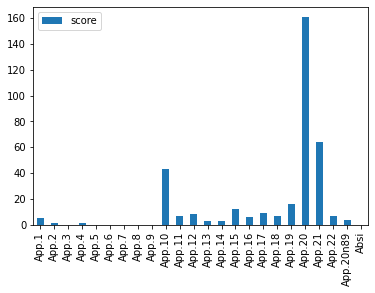

In [47]:
appendix.plot.bar()

In [56]:
b14 = pdata['1.4.6.1':'1.4.7.1'][:-1]

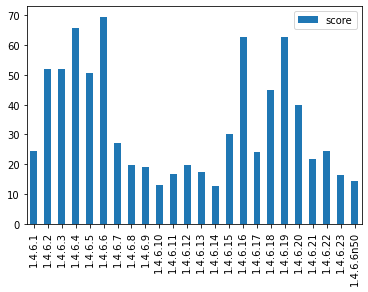

In [57]:
b14.plot.bar()

In [89]:
master_agg_para_list = {}
for para in treatise_paragraph_list:
    master_agg_para_list[para] = 0 
    
master_agg_chap_list = chapterScores(master_agg_para_list)

In [90]:
for filename in txt_dir:
    if 'txt' in filename:
        print('working on', filename)
        paper = newPaper('txts/'+filename)
        processPaper(paper)
        paperScoreSetter(paper)
        for para in master_agg_para_list.keys():
            master_agg_para_list[para] += paper.rawAggressiveScore[para]
        for chapter in master_agg_chap_list.keys():
            master_agg_chap_list[chapter] += paper.aggressiveRawChapterScore[chapter]
        print('done with', filename)

working on 1398236.txt
txts/1398236.txt processed
finished setting scores for txts/1398236.txt
done with 1398236.txt
working on project_muse_439818.txt
txts/project_muse_439818.txt processed
finished setting scores for txts/project_muse_439818.txt
done with project_muse_439818.txt
working on 31448-231447-1-PB.txt
txts/31448-231447-1-PB.txt processed
ABS28 generated an error while scoring: 'NoneType' object has no attribute 'end'
ABS28 generated an error while scoring: 'NoneType' object has no attribute 'end'
ABS28 generated an error while scoring: 'NoneType' object has no attribute 'end'
ABS28 generated an error while scoring: 'NoneType' object has no attribute 'end'
ABS28 generated an error while scoring: 'NoneType' object has no attribute 'end'
ABS28 generated an error while scoring: 'NoneType' object has no attribute 'end'
ABS28 generated an error while scoring: 'NoneType' object has no attribute 'end'
ABS28 generated an error while scoring: 'NoneType' object has no attribute 'end'


App.638 is not a paragraph in the Treatise, check the citation
App.639 is not a paragraph in the Treatise, check the citation
App.640 is not a paragraph in the Treatise, check the citation
App.641 is not a paragraph in the Treatise, check the citation
App.642 is not a paragraph in the Treatise, check the citation
App.643 is not a paragraph in the Treatise, check the citation
App.644 is not a paragraph in the Treatise, check the citation
App.645 is not a paragraph in the Treatise, check the citation
App.646 is not a paragraph in the Treatise, check the citation
App.647 is not a paragraph in the Treatise, check the citation
App.648 is not a paragraph in the Treatise, check the citation
App.649 is not a paragraph in the Treatise, check the citation
App.650 is not a paragraph in the Treatise, check the citation
App.651 is not a paragraph in the Treatise, check the citation
App.652 is not a paragraph in the Treatise, check the citation
App.653 is not a paragraph in the Treatise, check the c

1.1.8 is not a paragraph in the Treatise, check the citation
1.i.8 generated an error while scoring: '1.1.8'
2.1.47 is not a paragraph in the Treatise, check the citation
ii.1.47 generated an error while scoring: '2.1.47'
1.1.8 is not a paragraph in the Treatise, check the citation
1.i.8 generated an error while scoring: '1.1.8'
2.1.47 is not a paragraph in the Treatise, check the citation
ii.1.47 generated an error while scoring: '2.1.47'
1.1.8 is not a paragraph in the Treatise, check the citation
1.i.8 generated an error while scoring: '1.1.8'
2.1.47 is not a paragraph in the Treatise, check the citation
ii.1.47 generated an error while scoring: '2.1.47'
1.1.8 is not a paragraph in the Treatise, check the citation
1.i.8 generated an error while scoring: '1.1.8'
2.1.47 is not a paragraph in the Treatise, check the citation
ii.1.47 generated an error while scoring: '2.1.47'
finished setting scores for txts/penelhum-themes-book.txt
done with penelhum-themes-book.txt
working on project_

1.4.28 is not a paragraph in the Treatise, check the citation
1.4.28 generated an error while scoring: '1.4.28'
1.4.62 is not a paragraph in the Treatise, check the citation
1.4.62 generated an error while scoring: '1.4.62'
1.4.28 is not a paragraph in the Treatise, check the citation
1.4.28 generated an error while scoring: '1.4.28'
1.4.62 is not a paragraph in the Treatise, check the citation
1.4.62 generated an error while scoring: '1.4.62'
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
1.4.28 is not a paragraph in the Treatise, check the citation
1.4.28 generated an error while scoring: '1.4.28'
1.4.62 is not a paragraph in the Treatise, check the citation
1.4.62 generated an error while scoring: '1.4.62'
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
finished setting scores for txts/rocknack-imagined-causes-ch-10.txt
done wit

txts/thiel-early-modern-self-13-14.txt processed
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 gener

finished setting scores for txts/Gilead2008_Article_AHumeanArgumentForPersonalIden.txt
done with Gilead2008_Article_AHumeanArgumentForPersonalIden.txt
working on 26303717.txt
txts/26303717.txt processed
finished setting scores for txts/26303717.txt
done with 26303717.txt
working on project_muse_382731.txt
txts/project_muse_382731.txt processed
finished setting scores for txts/project_muse_382731.txt
done with project_muse_382731.txt
working on project_muse_385510.txt
txts/project_muse_385510.txt processed
finished setting scores for txts/project_muse_385510.txt
done with project_muse_385510.txt
working on WINKLER-2010-Philosophical_Books.txt
txts/WINKLER-2010-Philosophical_Books.txt processed
1.4.4.56 is not a paragraph in the Treatise, check the citation
1.4.4.56 generated an error while scoring: '1.4.4.56'
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
1.4.4.56 is not a paragraph in the Treatise, check the

txts/strawson-evident-connexion.txt processed
1.1.7.43 is not a paragraph in the Treatise, check the citation
1.1.7.6,43 generated an error while scoring: '1.1.7.43'
Abs78 is not a paragraph in the Treatise, check the citation
Abs§7,78 generated an error while scoring: 'Abs78'
1.4.3.77 is not a paragraph in the Treatise, check the citation
1.4.3.8,77 generated an error while scoring: '1.4.3.77'
1.2.4.67 is not a paragraph in the Treatise, check the citation
1.2.4.27,67 generated an error while scoring: '1.2.4.67'
1.2.5.56 is not a paragraph in the Treatise, check the citation
1.2.5.56 generated an error while scoring: '1.2.5.56'
1.4.2.66 is not a paragraph in the Treatise, check the citation
1.4.2.7,66 generated an error while scoring: '1.4.2.66'
App.63 is not a paragraph in the Treatise, check the citation
App§15,63 generated an error while scoring: 'App.63'
2.1.19 is not a paragraph in the Treatise, check the citation
2.1.19 generated an error while scoring: '2.1.19'
App.63 is not a 

finished setting scores for txts/project_muse_382933.txt
done with project_muse_382933.txt
working on pq9-0097.txt
txts/pq9-0097.txt processed
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
finished setting scores for txts/pq9-0097.txt
done with pq9-0097.txt
working on project_muse_383344.txt
txts/project_muse_383344.txt processed
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key erro

finished setting scores for txts/project_muse_383386.txt
done with project_muse_383386.txt
working on Kail-2008-European_Journal_of_Philosophy.txt
txts/Kail-2008-European_Journal_of_Philosophy.txt processed
692 generated a key error when trying to find matching paragraphs
692 generated an error while scoring: division by zero
692 generated a key error when trying to find matching paragraphs
692 generated an error while scoring: division by zero
692 generated a key error when trying to find matching paragraphs
692 generated an error while scoring: division by zero
finished setting scores for txts/Kail-2008-European_Journal_of_Philosophy.txt
done with Kail-2008-European_Journal_of_Philosophy.txt
working on ContentServer.asp-3.txt
txts/ContentServer.asp-3.txt processed
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying

 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
finished setting scores for txts/2660181.txt
done with 2660181.txt
working on project_muse_389409.txt
txts/project_muse_389409.txt processed
finished setting scores for txts/project_muse_389409.txt
done with project_muse_389409.txt
working on project_muse_511194.txt
txts/project_muse_511194.txt processed
finished setting scores for txts/project_muse_511194.txt
done with project_muse_511194.txt
working on 20009239.txt
txts/20009239.txt processed
960 generated a key error when trying to find matching paragraphs
960 generated an error while scoring: division by zero
960 generated a key error when trying to find matching paragraphs
960 generated an error while scoring: division by zero
960 generated a key error when trying to find matching pa

In [91]:
apdata = pd.DataFrame.from_dict(master_agg_para_list, orient='index', columns=['score'])

In [92]:
apdata['score'].sum()

5238.229

In [93]:
apdata['score'].sort_values()

0.1           0.000
2.3.7.9       0.000
2.3.8.1       0.000
2.3.8.2       0.000
2.3.8.3       0.000
             ...   
1.4.6.19     88.618
1.4.6.16    100.369
1.4.6.4     113.840
1.4.6.6     123.229
App.20      199.700
Name: score, Length: 1375, dtype: float64

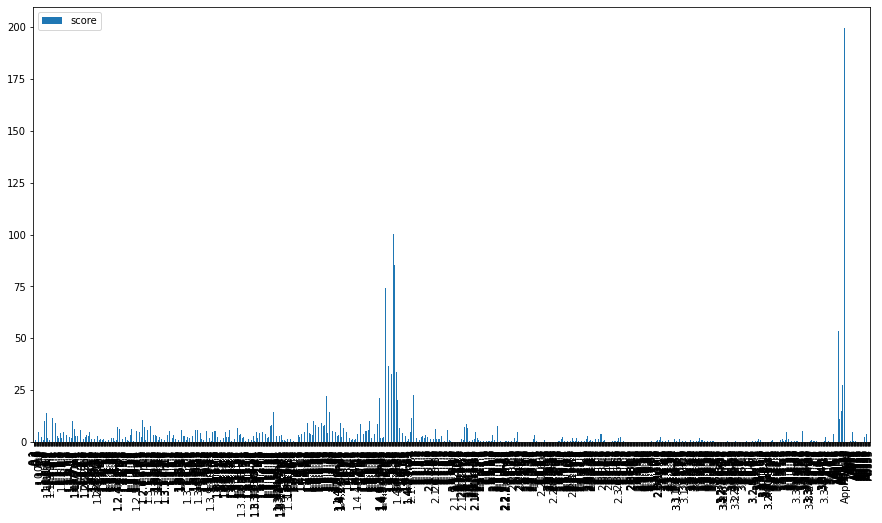

In [82]:
apdata.plot.bar(figsize=(15,8))

In [94]:
acdata = pd.DataFrame.from_dict(master_agg_chap_list, orient='index', columns=['score'])
acdata['score'].sum()

5238.229

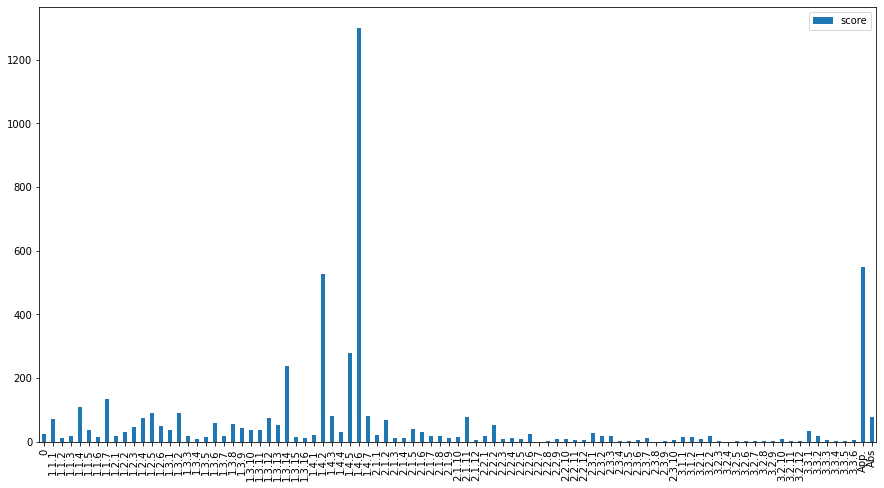

In [84]:
acdata.plot.bar(figsize=(15,8))

In [ ]:
#need a double digit check to get rid of the single digit argument numbering stuff that happens inside of parentheses.
#to do that, we need a 'more than one digit check':

#here's the basic num_check:
num_check = re.compile(r'(([, \-\–\—p\.]*)((?<!\d)\d{1,3}(?!\d)))+', re.I)
#now i want to make sure that we've got a two digit number at least.
#i think the best way to do that is to just add to pageNumCites only if the group match is len greater than 1:

#doing that greatly reduced the number of credits to 1.1.1.1 and took it off the top spot of the paragraph contributions.
#so i think that's the right choice.
#now let's see how different the strict and aggressive results are.

In [95]:
pdata['aggressive-score'] = apdata['score']

In [96]:
cdata['aggressive-score'] = acdata['score']

In [99]:
cdata['difference'] = abs(cdata['score']-cdata['aggressive-score'])

In [101]:
pdata['difference'] = abs(pdata['score']-pdata['aggressive-score'])

In [103]:
pdata

,score,aggressive-score,difference
0.1,0.0,0.000,0.000
0.2,0.0,0.000,0.000
0.3,0.0,0.999,0.999
0.4,0.0,0.999,0.999
0.5,0.0,1.832,1.832
...,...,...,...
Abs31,0.0,0.000,0.000
Abs32,0.0,0.000,0.000
Abs33,0.0,0.000,0.000
Abs34,0.0,0.000,0.000


In [104]:
cdata['difference'].sum()

2493.486

In [105]:
pdata['difference'].sum()

2493.4860000000003

In [118]:
#now to do this for relative cites. I'll do it in one pass

rel_agg_para_scores = relativeScoreCalc(master_strict_para_list)
rel_strict_para_scores = relativeScoreCalc(master_agg_para_list)
rel_agg_chap_scores = chapterScores(rel_agg_para_scores)
rel_strict_chap_scores = chapterScores(rel_strict_para_scores)

In [121]:
rel_p_data = pd.DataFrame.from_dict(rel_strict_para_scores, orient='index', columns=['strict-score'])
rel_ap_data = pd.DataFrame.from_dict(rel_agg_para_scores, orient='index', columns=['aggressive-score'])
rel_p_data['aggressive-score'] = rel_ap_data['aggressive-score']
rel_p_data['difference'] = abs(rel_p_data['strict-score'] - rel_p_data['aggressive-score'])
print(rel_p_data['strict-score'].sum())
print(rel_p_data['aggressive-score'].sum())
rel_p_data.sort_values('difference')[-20:]  

100.00000000000013
99.99999999999977


,strict-score,aggressive-score,difference
1.1.7.6,0.267190,0.056521,0.210669
1.4.6.9,0.504503,0.717175,0.212673
1.1.7.7,0.395477,0.180038,0.215439
App.17,0.527659,0.286621,0.241039
1.4.6.23,0.387192,0.630769,0.243577
App.20n89,0.379747,0.124251,0.255496
1.4.6.7,0.697927,0.964189,0.266262
1.4.5.5,0.504827,0.782366,0.277539
1.4.6.4,2.173254,2.471755,0.298501
1.4.2.39,0.663125,0.976680,0.313555


In [122]:
rel_c_data = pd.DataFrame.from_dict(rel_strict_chap_scores, orient='index', columns=['strict-score'])
rel_ac_data = pd.DataFrame.from_dict(rel_agg_chap_scores, orient='index', columns=['aggressive-score'])
rel_c_data['aggressive-score'] = rel_ac_data['aggressive-score']
rel_c_data['difference'] = abs(rel_c_data['strict-score'] - rel_c_data['aggressive-score'])
print(rel_c_data['strict-score'].sum())
print(rel_c_data['aggressive-score'].sum())

rel_c_data.sort_values('difference')[-20:]                          

100.00000000000011
99.9999999999998


,strict-score,aggressive-score,difference
3.2.2,0.362012,0.755151,0.393140
1.4.3,1.561463,1.987558,0.426096
1.3.1,0.718793,0.244561,0.474231
0,0.496275,0.000000,0.496275
1.3.2,1.753684,1.216227,0.537457
1.3.6,1.131050,0.547154,0.583896
2.1.2,1.330946,1.923298,0.592352
1.3.10,0.711271,0.079477,0.631794
1.3.9,0.840227,0.197050,0.643176
1.3.11,0.711901,0.014943,0.696958


In [124]:
total_diff_chap = rel_c_data['difference'].sum()
total_diff_chap

25.845682694890087

In [126]:
total_diff_para = rel_p_data['difference'].sum()
total_diff_para

38.21995447734684

In [127]:
#The results there are pretty reasonable! Differences at the paragraph level are a bit washed out 
#at the chapter level.
#it also makes sense that the biggest differences are at the paragraphs that have the most citation generally


What I want to do now is have the program loop over every article, create 8 csvs for each file—there are three dimensions each of which has two values:
strict-aggressive
raw-relative
paragraph-chapter

the basic distinction is strict v aggressive. if you calculate the raw paragraph score for each of those, you can then derive the relative and chapter scores.

But all of those are calculated by the ScoreSetter for individual articles.

For literature level data, though, the chapter and relative data can be derived by first looping over all the strict and aggressive raw paragraph data.

for cleaning these up I need a canonical way to write out these dictionary names so that it's easy to remember.

strict/agg_raw/relative_para/chapter
is probably the way to go.



In [35]:
#Working through literature level data file by file
#1. Get a text file from list of text files
import os
import csv
txts = os.listdir('txts')

#creating dictionaries to fill later, s_w_p and a_w_p, we'll use these later to create the
#lit level relative and chapter score sheets
lit_s_w_p = {}
for para in treatise_paragraph_list:
    lit_s_w_p[para] = 0 

lit_a_w_p = {}
for para in treatise_paragraph_list:
    lit_a_w_p[para] = 0 

#2. Create a paper object from the paper
for file in txts:
    if 'txt' in file:
        paper = newPaper('txts/'+file)
        #3. Process the paper processPaper(paper_obj)
        processPaper(paper)
        #4. Set thes scores for the paper object paperScoreSetter(paper_obj)
        paperScoreSetter(paper)
        #5. dump 8 csvs for the scores. fliename_strict/agg_raw/relative_para/chapter.csv file format
        paper.csvScoreDump()
        # Now I need to update the lit_s_w_p and lit_a_w_p dictionaries
        for para in paper.s_w_p.keys():
            lit_s_w_p[para] += paper.s_w_p[para]
        for para in paper.a_w_p.keys():
            lit_a_w_p[para] += paper.a_w_p[para]

def d_to_csv(dictionary, filename):
    file = open('csvs/'+filename+'.csv', 'w')
    csv_writer = csv.writer(file)
    for item in dictionary.items():
        csv_writer.writerow(item)
    file.close()

#dump the lit_s_w_p to csv
d_to_csv(lit_s_w_p, 'lit_s_w_p')
#7. create strict_relative_paragraph data, dump to csv
lit_s_l_p = relativeScoreCalc(lit_s_w_p)
d_to_csv(lit_s_l_p, 'lit_s_l_p')
#8. create strict_raw_chapter data, dump to csv 
lit_s_w_c = chapterScores(lit_s_w_p)
d_to_csv(lit_s_w_c, 'lit_s_w_c')
#9. create strict_relative_chapter data, dump to csv 
lit_s_l_c = chapterScores(lit_s_l_p)
d_to_csv(lit_s_l_c, 'lit_s_l_c')


#dump aggressive_raw_paragraph data to csv 
d_to_csv(lit_a_w_p, 'lit_a_w_p')
#11. From 10, create aggressive_relative_paragraph data, dump to csv 
lit_a_l_p = relativeScoreCalc(lit_a_w_p)
d_to_csv(lit_a_l_p, 'lit_a_l_p')
#12. From 10, create aggressive_raw_chapter data, dump to csv  
lit_a_w_c = chapterScores(lit_a_w_p)
d_to_csv(lit_a_w_c, 'lit_a_w_c')
#13. From 12, create aggressive_relative_chapter data, dump to csv 
lit_a_l_c = chapterScores(lit_a_l_p)
d_to_csv(lit_a_l_c, 'lit_a_l_c')
print('done generating data')

txts/1398236.txt processed
finished setting scores for txts/1398236.txt
csvs dumped
txts/project_muse_439818.txt processed
finished setting scores for txts/project_muse_439818.txt
csvs dumped
txts/31448-231447-1-PB.txt processed
ABS28 generated an error while scoring: 'NoneType' object has no attribute 'end'
ABS28 generated an error while scoring: 'NoneType' object has no attribute 'end'
ABS28 generated an error while scoring: 'NoneType' object has no attribute 'end'
ABS28 generated an error while scoring: 'NoneType' object has no attribute 'end'
ABS28 generated an error while scoring: 'NoneType' object has no attribute 'end'
ABS28 generated an error while scoring: 'NoneType' object has no attribute 'end'
ABS28 generated an error while scoring: 'NoneType' object has no attribute 'end'
ABS28 generated an error while scoring: 'NoneType' object has no attribute 'end'
finished setting scores for txts/31448-231447-1-PB.txt
csvs dumped
txts/20708617.txt processed
 generated a key error when 

 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
finished setting scores for txts/out.txt
csvs dumped
txts/Prolegomena_11_2_2012_Article_Lybaert.txt processed
1.4.62 is not a paragraph in the Treatise, check the citation
I.iv.62 generated an error while scoring: '1.4.62'
1.4.62 is not a paragraph in the Treatise, check the citation
I.iv.62 generated an error while scoring: '1.4.62'
1.4.62 is not a paragraph in the Treatise, check the citation
I.iv.62 generated an error while scoring: '1.4.62'
1.4.62 is not a paragraph in the Treatise, check the citation
I.iv.62 generated an error while scoring: '1.4.62'
1.4.62 is not a paragraph in the Treatise, check the citation
I.iv.62 generated an error while scoring: '1.4.62'
App.635 is not a paragraph in the Treatise, check the citation
Appendix635 generated an error while scoring: 'App.635'
App.635 is not a paragraph in the Treatise, check the citation
App.636 is not a 

txts/Schwerin2012_Article_HumeOnTheSelf.txt processed
finished setting scores for txts/Schwerin2012_Article_HumeOnTheSelf.txt
csvs dumped
txts/humes_theory_of_the_self_and_its_identity.txt processed
finished setting scores for txts/humes_theory_of_the_self_and_its_identity.txt
csvs dumped
txts/penelhum-themes-book.txt processed
1.1.8 is not a paragraph in the Treatise, check the citation
1.i.8 generated an error while scoring: '1.1.8'
2.1.47 is not a paragraph in the Treatise, check the citation
ii.1.47 generated an error while scoring: '2.1.47'
1.1.8 is not a paragraph in the Treatise, check the citation
1.i.8 generated an error while scoring: '1.1.8'
2.1.47 is not a paragraph in the Treatise, check the citation
ii.1.47 generated an error while scoring: '2.1.47'
1.1.8 is not a paragraph in the Treatise, check the citation
1.i.8 generated an error while scoring: '1.1.8'
2.1.47 is not a paragraph in the Treatise, check the citation
ii.1.47 generated an error while scoring: '2.1.47'
1.1.

txts/rocknack-imagined-causes-ch-10.txt processed
1.4.28 is not a paragraph in the Treatise, check the citation
1.4.28 generated an error while scoring: '1.4.28'
1.4.62 is not a paragraph in the Treatise, check the citation
1.4.62 generated an error while scoring: '1.4.62'
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
1.4.28 is not a paragraph in the Treatise, check the citation
1.4.28 generated an error while scoring: '1.4.28'
1.4.62 is not a paragraph in the Treatise, check the citation
1.4.62 generated an error while scoring: '1.4.62'
1.4.28 is not a paragraph in the Treatise, check the citation
1.4.28 generated an error while scoring: '1.4.28'
1.4.62 is not a paragraph in the Treatise, check the citation
1.4.62 generated an error while scoring: '1.4.62'
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
1.4.28 is not a paragraph 

 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
finished setting scores for txts/project_muse_596651.txt
csvs dumped
txts/2184977.txt processed
finished setting scores for txts/2184977.txt
csvs dumped
txts/project_muse_383238.txt processed
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching 

txts/20126883.txt processed
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
finished setting scores for txts/20126883.txt
csvs dumped
txts/pq21-0324.txt processed
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 ge

txts/ContentServer.asp-8.txt processed
finished setting scores for txts/ContentServer.asp-8.txt
csvs dumped
txts/project_muse_382726.txt processed
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
finished setting scores for txts/project_muse_382726.txt
csvs dumped
txts/9780470776377.ch8.txt processed
1.4.7.20 is not a paragraph in the Treatise, check the citation
1.4.7.20 generated an error while scoring: '1.4.7.20'
1.3.15.35 is not a paragraph in the Treatise, check the citation
1.3.15.35 generated an error while scoring: '1.3.15.35'
1.4.7.20 is not a paragraph in the Treatise, check the citation
1.4.7.20 generated an error while scoring: '1.4.7.20'
1.3.15.35 is

App.63 is not a paragraph in the Treatise, check the citation
App§15,63 generated an error while scoring: 'App.63'
2.1.19 is not a paragraph in the Treatise, check the citation
2.1.19 generated an error while scoring: '2.1.19'
App.63 is not a paragraph in the Treatise, check the citation
App§15,63 generated an error while scoring: 'App.63'
1.3.7.10 is not a paragraph in the Treatise, check the citation
1.3.7.3,10 generated an error while scoring: '1.3.7.10'
1.1.3.10 is not a paragraph in the Treatise, check the citation
1.1.3.4,10 generated an error while scoring: '1.1.3.10'
1.1.4.24 is not a paragraph in the Treatise, check the citation
1.1.4.1,24 generated an error while scoring: '1.1.4.24'
1.1.7.42 is not a paragraph in the Treatise, check the citation
1.1.7.15,42 generated an error while scoring: '1.1.7.42'
1.1.4.13 is not a paragraph in the Treatise, check the citation
1.1.4.1,13 generated an error while scoring: '1.1.4.13'
1.1.4.24 is not a paragraph in the Treatise, check the ci

csvs dumped
txts/ContentServer.asp-7.txt processed
finished setting scores for txts/ContentServer.asp-7.txt
csvs dumped
txts/project_muse_383386.txt processed
finished setting scores for txts/project_muse_383386.txt
csvs dumped
txts/Kail-2008-European_Journal_of_Philosophy.txt processed
692 generated a key error when trying to find matching paragraphs
692 generated an error while scoring: division by zero
692 generated a key error when trying to find matching paragraphs
692 generated an error while scoring: division by zero
692 generated a key error when trying to find matching paragraphs
692 generated an error while scoring: division by zero
finished setting scores for txts/Kail-2008-European_Journal_of_Philosophy.txt
csvs dumped
txts/ContentServer.asp-3.txt processed
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when try

txts/533Cottrell.txt processed
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generat

done generating data


In [15]:
#generating similarity data
#Let's start with relative data only. That gives us four sets to work with
#1. create a data frame from literature level strict_relative_paragraph data csv
#for each file in the list of text files, create a data frame from that file's strict_relative_paragraph data csv
    #add that score column to the literature level data
    #dump this literature level comparative data to a csv, comparison_strict_relative_paragraph_data.csv
#2. create a data frame from literature level aggressive_relative_paragraph data csv
#for each file in the list of text files, create a data frame from that file's aggresive_relative_paragraph data csv
    #add that score column to the literature level data
    #dump this literature level comparative data to a csv, comparison_aggressive_relative_paragraph_data.csv
#3. create a data frame from literature level strict_relative_chapter data data csv
#for each file in the list of text files, create a data frame from that file's strict_relative_chapter data csv
    #add that score column to the literature level data
    #dump this literature level comparative data to a csv, strict_relative_chapter_paragraph_data.csv
#4. create a data frame from literature level aggressive_relative_chapter data data csv
#for each file in the list of text files, create a data frame from that file's aggressive_relative_chapter data csv
    #add that score column to the literature level data
    #dump this literature level comparative data to a csv, aggressive_relative_chapter_paragraph_data.csv


In [62]:
#1. create a data frame from literature level strict_relative_paragraph data csv
s_l_p = pd.read_csv('csvs/lit_s_l_p.csv', index_col=0, names=['Literature'])

In [63]:
#for each file in the list of text files:
for file in txts:
    if 'txt' in file:
        csv_base_name = 'csvs/'+file[:-4]
        csv_s_l_p_name = csv_base_name+'-s-l-p.csv'
        #create a data frame from that file's strict_relative_paragraph data csv
        article_df = pd.read_csv(csv_s_l_p_name, index_col=0, names=[file[:-4]])
        #add that score column to the literature level data
        s_l_p[file[:-4]] = article_df[file[:-4]]

In [64]:
#dump this literature level comparative data to a csv, comparison_strict_relative_paragraph_data.csv
s_l_p.to_csv('s_l_p_data.csv')

In [65]:
#2. create a data frame from literature level aggressive_relative_paragraph data csv
#for each file in the list of text files, create a data frame from that file's aggresive_relative_paragraph data csv
    #add that score column to the literature level data
    #dump this literature level comparative data to a csv, comparison_aggressive_relative_paragraph_data.csv
a_l_p = pd.read_csv('csvs/lit_a_l_p.csv', index_col=0, names=['Literature'])
for file in txts:
    if 'txt' in file:
        csv_base_name = 'csvs/'+file[:-4]
        csv_a_l_p_name = csv_base_name+'-a-l-p.csv'
        #create a data frame from that file's strict_relative_paragraph data csv
        article_df = pd.read_csv(csv_a_l_p_name, index_col=0, names=[file[:-4]])
        #add that score column to the literature level data
        a_l_p[file[:-4]] = article_df[file[:-4]]
a_l_p.to_csv('a_l_p_data.csv')

In [66]:
#3. create a data frame from literature level strict_relative_chapter data data csv
#for each file in the list of text files, create a data frame from that file's strict_relative_chapter data csv
    #add that score column to the literature level data
    #dump this literature level comparative data to a csv, strict_relative_chapter_paragraph_data.csv
s_l_c = pd.read_csv('csvs/lit_s_l_c.csv', index_col=0, names=['Literature'])
for file in txts:
    if 'txt' in file:
        csv_base_name = 'csvs/'+file[:-4]
        csv_s_l_c_name = csv_base_name+'-s-l-c.csv'
        #create a data frame from that file's strict_relative_paragraph data csv
        article_df = pd.read_csv(csv_s_l_c_name, index_col=0, names=[file[:-4]])
        #add that score column to the literature level data
        s_l_c[file[:-4]] = article_df[file[:-4]]
s_l_c.to_csv('s_l_c_data.csv')

In [67]:
#4. create a data frame from literature level aggressive_relative_chapter data data csv
#for each file in the list of text files, create a data frame from that file's aggressive_relative_chapter data csv
    #add that score column to the literature level data
    #dump this literature level comparative data to a csv, aggressive_relative_chapter_paragraph_data.csv
a_l_c = pd.read_csv('csvs/lit_a_l_c.csv', index_col=0, names=['Literature'])
for file in txts:
    if 'txt' in file:
        csv_base_name = 'csvs/'+file[:-4]
        csv_a_l_c_name = csv_base_name+'-a-l-c.csv'
        #create a data frame from that file's strict_relative_paragraph data csv
        article_df = pd.read_csv(csv_a_l_c_name, index_col=0, names=[file[:-4]])
        #add that score column to the literature level data
        a_l_c[file[:-4]] = article_df[file[:-4]]
a_l_c.to_csv('a_l_c_data.csv')

Okay, so I now have exported 4 csvs which have all the relative citation data for each aggressive/strict paragraph/chapter data set. Each CSV can be imported into a data frame and I can go back to the similarity notebook to generate the similarity scores.

In [11]:
def df_col_similarity(df, colx, coly):
    total_diff = 0
    for para in df.index:
        total_diff += abs(df[colx][para] - df[coly][para])
    return total_diff

Let's start with s_l_c

In [73]:
s_l_c_similarity = pd.DataFrame(index=s_l_c.columns, columns=s_l_c.columns)
for column in s_l_c_similarity.columns:
    for ind in s_l_c_similarity.index:
        s_l_c_similarity[column][ind] = df_col_similarity(s_l_c,column,ind)
        

In [75]:
s_l_c_similarity.to_csv('similarity_scores/s_l_c_similarity.csv')

In [76]:
a_l_c_similarity = pd.DataFrame(index=a_l_c.columns, columns=a_l_c.columns)
for column in a_l_c_similarity.columns:
    for ind in a_l_c_similarity.index:
        a_l_c_similarity[column][ind] = df_col_similarity(a_l_c,column,ind)
a_l_c_similarity.to_csv('similarity_scores/a_l_c_similarity.csv')

In [77]:
s_l_p_similarity = pd.DataFrame(index=s_l_p.columns, columns=s_l_p.columns)
for column in s_l_p_similarity.columns:
    for ind in s_l_p_similarity.index:
        s_l_p_similarity[column][ind] = df_col_similarity(s_l_p,column,ind)
s_l_p_similarity.to_csv('similarity_scores/s_l_p_similarity.csv')

In [ ]:
a_l_p_similarity = pd.DataFrame(index=a_l_p.columns, columns=a_l_p.columns)
for column in a_l_p_similarity.columns:
    for ind in a_l_p_similarity.index:
        a_l_p_similarity[column][ind] = df_col_similarity(a_l_p,column,ind)
a_l_p_similarity.to_csv('similarity_scores/a_l_p_similarity.csv')

In [48]:
def p_to_dict(paper):
    od = {}
    od['name'] = paper.name
    norton_cites_out = []
    for cite in paper.nortonCites:
        norton_cites_out.append(c_to_dict(cite))
    od['nortonCites'] = norton_cites_out
    sbn_cites_out = []
    for cite in paper.sbnCites:
        sbn_cites_out.append(c_to_dict(cite))
    od['sbnCites'] = sbn_cites_out
    raw_out = []
    for cite in paper.rawParenthesesCapture:
        raw_out.append(c_to_dict(cite))
    od['rawParenthesesCapture'] = raw_out
    t_out = []
    for cite in paper.tCites:
        t_out.append(c_to_dict(cite))
    od['tCites'] = t_out
    pageNumOut = []
    for cite in paper.pageNumCites:
        pageNumOut.append(c_to_dict(cite))
    od['pageNumCites'] = pageNumOut
    od['rawNortonScore'] = paper.rawNortonScore
    od['rawSbnScore'] = paper.rawSbnScore
    od['rawTScore'] = paper.rawTScore
    od['rawPageNumScore'] = paper.rawPageNumScore
    od['a_l_p'] = paper.a_l_p
    od['a_w_p'] = paper.a_w_p
    od['s_l_p'] = paper.s_l_p
    od['s_w_p'] = paper.s_w_p
    od['totalStrictCites'] = paper.totalStrictCites
    od['totalAggressiveCites'] = paper.totalAggressiveCites
    od['s_w_c'] = paper.s_w_c
    od['s_l_c'] = paper.s_l_c
    od['a_w_c'] = paper.a_w_c
    od['a_l_c'] = paper.a_l_c
    od['biblio'] = paper.biblio
    
    return od

def c_to_dict(cite):
    od = {}
    od['order'] = cite.order
    od['paper'] = cite.paper
    od['startPoint'] = cite.startPoint
    od['endPoint'] = cite.endPoint
    od['rawCitationText'] = cite.rawCitationText
    od['cleanedCitation'] = cite.cleanedCitation
    
    return od
    

In [49]:
def p_from_dict(in_dict):
    paper = newPaper(in_dict['name'])
    for cite in in_dict['nortonCites']:
        paper.nortonCites.append(c_from_dict(cite))
    for cite in in_dict['sbnCites']:
        paper.sbnCites.append(c_from_dict(cite))
    for cite in in_dict['rawParenthesesCapture']:
        paper.rawParenthesesCapture.append(c_from_dict(cite))
    for cite in in_dict['tCites']:
        paper.tCites.append(c_from_dict(cite))
    for cite in in_dict['pageNumCites']:
        paper.pageNumCites.append(c_from_dict(cite))
    paper.rawNortonScore = in_dict['rawNortonScore']
    paper.rawSbnScore = in_dict['rawSbnScore']
    paper.rawTScore = in_dict['rawTScore']
    paper.rawPageNumScore = in_dict['rawPageNumScore']
    paper.totalStrictCites = in_dict['totalStrictCites']
    paper.totalAggressiveCites = in_dict['totalAggressiveCites']
    paper.a_l_p = in_dict['a_l_p']
    paper.a_w_p = in_dict['a_w_p']
    paper.a_l_c = in_dict['a_l_c']
    paper.a_w_c = in_dict['a_w_c']
    paper.s_l_p = in_dict['s_l_p']
    paper.s_w_p = in_dict['s_w_p']
    paper.s_l_c = in_dict['s_l_c']
    paper.s_w_c = in_dict['s_w_c']
    paper.biblio = in_dict['biblio']
    
    return paper


def c_from_dict(in_dict):
    cite = Citation(in_dict['paper'], in_dict['order'], in_dict['rawCitationText'])
    cite.startPoint = in_dict['startPoint']
    cite.endPoint = in_dict['endPoint']
    cite.cleanedCitation = in_dict['cleanedCitation']
    
    return cite

In [17]:
cpaper = newPaper('533Cottrell')
processPaper(cpaper)
paperScoreSetter(cpaper)
cotd = p_to_dict(cpaper)

533Cottrell processed
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generated a key 

In [18]:
cotd['s_w_p']['1.4.6.4']

1.0

In [19]:
cotd['nortonCites'][5]['cleanedCitation']

'App1'

In [20]:
revpaper = p_from_dict(cotd)

In [21]:
revpaper.nortonCites[5].cleanedCitation

'App1'

In [22]:
print(cpaper.s_w_p == revpaper.s_w_p)
print(cpaper.s_l_p == revpaper.s_l_p)
print(cpaper.s_w_c == revpaper.s_w_c)
print(cpaper.s_l_c == revpaper.s_l_c)
print(cpaper.a_w_p == revpaper.a_w_p)
print(cpaper.a_l_p == revpaper.a_l_p)
print(cpaper.a_w_c == revpaper.a_w_c)
print(cpaper.a_l_c == revpaper.a_l_c)

True
True
True
True
True
True
True
True


In [23]:
cotd

{'name': '533Cottrell',
 'nortonCites': [{'order': 1,
   'paper': '533Cottrell',
   'startPoint': 307,
   'endPoint': 314,
   'rawCitationText': '1.4.6.4',
   'cleanedCitation': '1.4.6.4'},
  {'order': 2,
   'paper': '533Cottrell',
   'startPoint': 315,
   'endPoint': 323,
   'rawCitationText': '1.4.6.19',
   'cleanedCitation': '1.4.6.19'},
  {'order': 3,
   'paper': '533Cottrell',
   'startPoint': 324,
   'endPoint': 329,
   'rawCitationText': 'Abs28',
   'cleanedCitation': 'Abs28'},
  {'order': 4,
   'paper': '533Cottrell',
   'startPoint': 330,
   'endPoint': 335,
   'rawCitationText': 'App10',
   'cleanedCitation': 'App10'},
  {'order': 5,
   'paper': '533Cottrell',
   'startPoint': 2265,
   'endPoint': 2275,
   'rawCitationText': '1.4.6.5–22',
   'cleanedCitation': '1.4.6.5–22'},
  {'order': 6,
   'paper': '533Cottrell',
   'startPoint': 2399,
   'endPoint': 2403,
   'rawCitationText': 'App1',
   'cleanedCitation': 'App1'},
  {'order': 7,
   'paper': '533Cottrell',
   'startPoint'

In [24]:
import json
file = open('533Cottrell.json', 'w')
json.dump(cotd, file)
file.close()

In [25]:
jfile = open('533Cottrell.json', 'r')
jd = json.load(jfile)
jpaper = p_from_dict(jd)
jfile.close()

In [20]:
import pandas as pd


In [26]:
refs = pd.read_csv('List-of-Refs.csv', header=0)

In [28]:
refs

,Author,Title of Work,Journal,Volume,Issue,Pages,Year,Book Title,Editor,Review?,Symposium?,Downloaded?,Sample?,Citation Format,Citation Notes,Filename
0,"Ainslie, Donald C.",The Problem of the National Self in Hume\textq...,Hume Studies,21.0,2,289--313,1995.0,NaN,NaN,NaN,NaN,yes,NaN,SBN,Stanadard SBN of (T 277),project_muse_382726.pdf
1,"Ainslie, Donald C.",Scepticism About Persons in Book II of Hume's ...,Journal of the History of Philosophy,37.0,3,469--492,1999.0,NaN,NaN,NaN,NaN,Yes,Yes,SBN,NaN,project_muse_228761.pdf
2,"Ainslie, Donald C.","Review: Hume, a Scottish Socrates?",Canadian Journal of Philosophy,33.0,1,133--154,2003.0,NaN,NaN,yes,NaN,yes,NaN,N&N,NaN,40232176.pdf
3,"Ainslie, Donald C.",Projection and Realism in Hume's Philosophy. B...,Metaphilosophy,40.0,2,292--296,2009.0,NaN,NaN,yes,NaN,yes,NaN,N&N,NaN,24439665.pdf
4,"Ainslie, Donald C.",Hume on Personal Identity,NaN,NaN,NaN,140-157,2008.0,A Companion to Hume,Elizabeth Radcliffe,NaN,NaN,yes,NaN,NaN,NaN,1173780.pdf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,"McINTYRE, J. L.",Is Hume's Self Consistent?,NaN,NaN,NaN,NaN,1979.0,McGill Hume Studies,Norton,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140,"Morick, Harold",Introduction to the Philosophy of Mind: Readin...,NaN,NaN,NaN,NaN,1970.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141,"Nafstad, Petter",Pasjoner Og Personer En Analyse Av David Humes...,NaN,NaN,NaN,NaN,1999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142,"Vigus, James",From Personal Identity to Character : Sterne a...,NaN,NaN,NaN,NaN,2013.0,Shandean Humour in English and German Literatu...,"Viewig, Klaus; Vigus, James; Wheeler, Kathleen M.",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
na_in_dl = refs['Downloaded?'].notna()
na_in_dl

0       True
1       True
2       True
3       True
4       True
       ...  
139    False
140    False
141    False
142    False
143    False
Name: Downloaded?, Length: 144, dtype: bool

In [30]:
dl_no_na = refs[na_in_dl]
dl_no_na

,Author,Title of Work,Journal,Volume,Issue,Pages,Year,Book Title,Editor,Review?,Symposium?,Downloaded?,Sample?,Citation Format,Citation Notes,Filename
0,"Ainslie, Donald C.",The Problem of the National Self in Hume\textq...,Hume Studies,21.0,2,289--313,1995.0,NaN,NaN,NaN,NaN,yes,NaN,SBN,Stanadard SBN of (T 277),project_muse_382726.pdf
1,"Ainslie, Donald C.",Scepticism About Persons in Book II of Hume's ...,Journal of the History of Philosophy,37.0,3,469--492,1999.0,NaN,NaN,NaN,NaN,Yes,Yes,SBN,NaN,project_muse_228761.pdf
2,"Ainslie, Donald C.","Review: Hume, a Scottish Socrates?",Canadian Journal of Philosophy,33.0,1,133--154,2003.0,NaN,NaN,yes,NaN,yes,NaN,N&N,NaN,40232176.pdf
3,"Ainslie, Donald C.",Projection and Realism in Hume's Philosophy. B...,Metaphilosophy,40.0,2,292--296,2009.0,NaN,NaN,yes,NaN,yes,NaN,N&N,NaN,24439665.pdf
4,"Ainslie, Donald C.",Hume on Personal Identity,NaN,NaN,NaN,140-157,2008.0,A Companion to Hume,Elizabeth Radcliffe,NaN,NaN,yes,NaN,NaN,NaN,1173780.pdf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,"Schwerin, Alan",Hume's Labyrinth: A Search for the Self,NaN,NaN,NaN,NaN,2012.0,NaN,NaN,yes (i think),NaN,can't find,NaN,NaN,NaN,NaN
128,"Sirswal, Desh Raj",Hume\textquoterights Discussion on the Persona...,Bihar Jounal of Philosophical Research,NaN,0,189--197,2005.0,NaN,NaN,NaN,NaN,can't find,NaN,NaN,NaN,NaN
129,"Tortolero, Mario Edmundo Ch\'avez",Sobre la Existencia de Las Percepciones En El ...,NaN,NaN,NaN,267--288,2018.0,El concepto de substancia de Spinoza a Hegel,"Ben\'itez, Grobet; Ramos{-}Alarcon, Luis",NaN,NaN,can't find,NaN,NaN,NaN,NaN
130,"Tweyman, Stanley",Hume's Attempted Paradigms for Explaining the ...,The European Legacy,2.0,2,363--369,1997.0,NaN,NaN,NaN,NaN,can't find,NaN,NaN,NaN,NaN


In [31]:
dl_yes = dl_no_na['Downloaded?'].str.contains('yes', case=False)
dl_files = dl_no_na[dl_yes]

In [32]:
dl_files

,Author,Title of Work,Journal,Volume,Issue,Pages,Year,Book Title,Editor,Review?,Symposium?,Downloaded?,Sample?,Citation Format,Citation Notes,Filename
0,"Ainslie, Donald C.",The Problem of the National Self in Hume\textq...,Hume Studies,21.0,2,289--313,1995.0,NaN,NaN,NaN,NaN,yes,NaN,SBN,Stanadard SBN of (T 277),project_muse_382726.pdf
1,"Ainslie, Donald C.",Scepticism About Persons in Book II of Hume's ...,Journal of the History of Philosophy,37.0,3,469--492,1999.0,NaN,NaN,NaN,NaN,Yes,Yes,SBN,NaN,project_muse_228761.pdf
2,"Ainslie, Donald C.","Review: Hume, a Scottish Socrates?",Canadian Journal of Philosophy,33.0,1,133--154,2003.0,NaN,NaN,yes,NaN,yes,NaN,N&N,NaN,40232176.pdf
3,"Ainslie, Donald C.",Projection and Realism in Hume's Philosophy. B...,Metaphilosophy,40.0,2,292--296,2009.0,NaN,NaN,yes,NaN,yes,NaN,N&N,NaN,24439665.pdf
4,"Ainslie, Donald C.",Hume on Personal Identity,NaN,NaN,NaN,140-157,2008.0,A Companion to Hume,Elizabeth Radcliffe,NaN,NaN,yes,NaN,NaN,NaN,1173780.pdf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,"Waxman, Wayne",Hume's Quandary Concerning Personal Identity,Hume Studies,18.0,2,233--253,1992.0,NaN,NaN,NaN,NaN,yes,NaN,SBN,Standard SBN (T 251-253),project_muse_388507.pdf
98,"Winkler, Kenneth P.",\textquotedblleftAll Is Revolution in Us\textq...,Hume Studies,26.0,1,3--40,2000.0,NaN,NaN,NaN,NaN,Yes,No,NaN,NaN,project_muse_383238.pdf
99,"Winkler, Kenneth P.",P.J.E. Kail's Projection and Realism in Hume's...,Philosophical Books,51.0,3,144--159,2010.0,NaN,NaN,yes,NaN,yes,NaN,N&N,"Either (Treatise, 1.2.3.4) or (T 1.2.3.4) or n...",WINKLER-2010-Philosophical_Books.pdf
100,"Yang, Xiaomei",Hume's View on Personal Identity: Scepticism o...,History of Philosophy Quarterly,15.0,1,37--56,1998.0,NaN,NaN,NaN,NaN,yes,NaN,SBN,just a page number (654),27744766.pdf


In [33]:
import os
raw_txt_list = os.listdir('txts')
clean_txt_list = []
for file in raw_txt_list:
    if 'txt' in file:
        clean_txt_list.append(file)
print(len(raw_txt_list))
print(len(clean_txt_list))

102
101


In [28]:
filename_filter = dl_files['Filename'].str.contains('23598030')

In [29]:
print(dl_files[filename_filter]['Title of Work'].values[0])

Review: Theil, Udo, \emphThe Early Modern Subject: Self-Consciousness and Personal Identity From Descartes to Hume


In [34]:
for file in clean_txt_list:
    try:
        filename_filter = dl_files['Filename'].str.contains(file[:-4])
        author = dl_files[filename_filter]['Author'].values[0]
        print(file[:-4], author)
    except Exception as e:
        print(e)

1398236 Mathur, D. C.
project_muse_439818 Kail, P. J. E.
31448-231447-1-PB Gandarillas, Francisco Pereira
20708617 GalIagher, Shaun
project_muse_388443 Henderson, Robert S.
ipq_2004_0044_0002_0276_0278&pdfname=ipq_2004_0044_0002_0134_0136 Flage, Daniel E.
2653404-2 Roth, Abraham Sesshu
acpq_1990_0064_0002_0233_0247 Roth, Robert J.
project_muse_388509 Pappas, George S.
out Flage, Daniel E.; Glass, Ronald J.
Prolegomena_11_2_2012_Article_Lybaert Lybaert, Fauve
acprof-9780199229505-chapter-6 Kail, P. J. E.
Schwerin2012_Article_HumeOnTheSelf Schwerin, Alan
humes_theory_of_the_self_and_its_identity Ashley, Lawrence; Stack, Michael
penelhum-themes-book Penelhum, Terence
project_muse_389389 Lesser, Harry
20131803 Bricke, John
1173639 Ware, Owen; Ainslie, Donald C.
40232176 Ainslie, Donald C.
SIRTCO.1 Sirswal, Desh Raj
project_muse_403836 Carlson, \AA{}sa
Levin2007_Article_BundlingHumeWithKripkenstein Levin, Michael E.
2182635 Penelhum, Terence
project_muse_439820 Garrett, Don
20532746 Loeb, L

In [31]:
#so, all txt files can be linked back to their bibliographic information
#now i need to go the other way, try to find the missing txt files for allegedly downloaded files

In [35]:
biblio_filenames = []
for filename in dl_files['Filename'].values:
    biblio_filenames.append(filename[:-4])
biblio_filenames
clean_filenames = []
for file in clean_txt_list:
    clean_filenames.append(file[:-4])

In [36]:
unmatched_files = []
for file in biblio_filenames:
    if file in clean_filenames:
        print(file, 'matched!')
    else:
        print(file, 'not found in txts!')
        unmatched_files.append(file)
unmatched_files

project_muse_382726 matched!
project_muse_228761 matched!
40232176 matched!
24439665 matched!
1173780 matched!
humes_theory_of_the_self_and_its_identity matched!
20126883 matched!
20131803 matched!
1130384 matched!
project_muse_365207 matched!
pq9-0097 matched!
project_muse_403836 matched!
2106947 matched!
533Cottrell matched!
Projection and Realism in Hume's Philosophy coventry review matched!
fzt013 matched!
project_muse_390704 matched!
26303717 matched!
project_muse_38 not found in txts!
project_muse_385510 matched!
ipq_2004_0044_0002_0276_0278&pdfname=ipq_2004_0044_0002_0134_0136 matched!
Flage_et_al-1984-The_Southern_Journal_of_Philosophy matched!
20708617 matched!
31448-231447-1-PB matched!
10088-Texto del artículo-10169-1-10-20110601 matched!
2184977 matched!
2660181 matched!
project_muse_439820 matched!
Gilead2008_Article_AHumeanArgumentForPersonalIden matched!
1399612 matched!
project_muse_596651 matched!
ContentServer.asp-2 matched!
ContentServer.asp-3 matched!
project_muse_3

['project_muse_38', 'acpq_1990_0064_0002_0233_']

In [33]:
filenamefilter = dl_files['Filename'].str.contains('acpq_1990_0064_0002_0233')
dl_files[filenamefilter]

,Author,Title of Work,Journal,Volume,Issue,Pages,Year,Book Title,Editor,Review?,Symposium?,Downloaded?,Sample?,Citation Format,Citation Notes,Filename
79,"Roth, Robert J.",Hume and James on Personal Identity,American Catholic Philosophical Quarterly,64.0,2,233--247,1990.0,NaN,NaN,NaN,NaN,yes,NaN,SBN,tricky. All citations to hume are (p. 256) sty...,acpq_1990_0064_0002_0233_0247


Okay so far, then, i can match up each txt file with its bibliographic information. the next good thing to do would be attach the philpapers identifiers to these for clean linking to philpapers sites.

the final step then would be to put together JSON files that include:
a document for the bibliographic information
a document for all the citation information.

Once I have that I'll be in a position to put the data into the database and then build the website.

Actually, though, I'm going to need to rerun and recalculate all teh searches and comparative data because i've added a couple pieces! That will come last once i'm sure i've got everything else in place

Before I do that I'll go back and edit the class files and function lists to add the work I've done here.

In [37]:
#Starting to think through creating the Paper with bibliographic information. 
#1. Create the newPaper file
#2. use the matching datafram to pull:
#Author
#Title of work
#Journal
#Volume
#Issue
#Pages
#Year
#Book Title
#3. 
def biblioGenerator(filename, data_frame):
    filename_filter = data_frame['Filename'].str.contains(filename)
    df_row = data_frame[filename_filter]
    do = {}
    do['Author'] = df_row['Author'].values[0]
    do['Title of Work'] = df_row['Title of Work'].values[0]
    do['Journal'] = df_row['Journal'].values[0]
    do['Volume'] = df_row['Volume'].values[0]
    do['Issue'] = df_row['Issue'].values[0]
    do['Pages'] = df_row['Pages'].values[0]
    do['Year'] = df_row['Year'].values[0]
    do['Book Title'] = df_row['Book Title'].values[0]
    
    return do
    
def biblioSetter(paper_obj, data_frame):
    paper_obj.biblio = biblioGenerator(paper_obj.name, data_frame)
    

In [38]:
cottrell_pap = newPaper('533Cottrell')

In [39]:
cotpap = newPaper('533Cottrell')

In [40]:
cotpap.parenthesesCapture()

In [41]:
biblioSetter(cotpap, dl_files)

In [42]:
cotpap.biblio

{'Author': 'Cottrell, Jonathan',
 'Title of Work': "Minds, Composition, and Hume's Skepticism in the Appendix",
 'Journal': 'Philosophical Review',
 'Volume': 124.0,
 'Issue': '4',
 'Pages': '533--569',
 'Year': 2015.0,
 'Book Title': nan}

In [43]:
def final_single_process(filename, data_frame):
    paper = newPaper(filename)
    processPaper(paper)
    paperScoreSetter(paper)
    biblioSetter(paper, data_frame)
    
    return paper

In [50]:
final_test = final_single_process('533Cottrell', dl_files)

533Cottrell processed
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generated a key error when trying to find matching paragraphs
i generated a key 

In [51]:
final_test.biblio

{'Author': 'Cottrell, Jonathan',
 'Title of Work': "Minds, Composition, and Hume's Skepticism in the Appendix",
 'Journal': 'Philosophical Review',
 'Volume': 124.0,
 'Issue': '4',
 'Pages': '533--569',
 'Year': 2015.0,
 'Book Title': nan}

In [46]:
final_test.totalStrictCites

202

In [47]:
final_test.totalAggressiveCites

351

In [52]:
pft = p_to_dict(final_test)

In [57]:
cpft = p_from_dict(pft)

In [69]:
cpft.name

'533Cottrell'

In [72]:
for paper in dl_files['Filename'].values:
    print(paper[:-4])

project_muse_382726
project_muse_228761
40232176
24439665
1173780
humes_theory_of_the_self_and_its_identity
20126883
20131803
1130384
project_muse_365207
pq9-0097
project_muse_403836
2106947
533Cottrell
Projection and Realism in Hume's Philosophy coventry review
fzt013
project_muse_390704
26303717
project_muse_38
project_muse_385510
ipq_2004_0044_0002_0276_0278&pdfname=ipq_2004_0044_0002_0134_0136
Flage_et_al-1984-The_Southern_Journal_of_Philosophy
20708617
31448-231447-1-PB
10088-Texto del artículo-10169-1-10-20110601
2184977
2660181
project_muse_439820
Gilead2008_Article_AHumeanArgumentForPersonalIden
1399612
project_muse_596651
ContentServer.asp-2
ContentServer.asp-3
project_muse_388443
acpq_1995_0069_0003_0485_0501&pdfname=acpq_1995_0069_0003_0091_0107
27745095
ContentServer.asp-4
ContentServer.asp-5
project_muse_439818
acprof-9780199229505-chapter-6
Kail-2008-European_Journal_of_Philosophy
project_muse_389389
Levin2007_Article_BundlingHumeWithKripkenstein
20532746
project_muse_388

I have a list of files
I have a database to tie those files to bibliographic information
I can search and score these and export them with strict and aggressive chapter and paragraph scores to json format.

That can be a persistent database

Going forward what I need to do is to add a filename and a text copy of the file

In [76]:
for filename in dl_files['Filename'].values:
    try:
        #process the paper, using dl_files to create bibliographic info
        processed_paper = final_single_process(filename[:-4], dl_files)
        #turn the processed paper into a dictinoary
        paper_dictionary = p_to_dict(processed_paper)
    except:
        print('Error processing', filename[:-4])
    #create the json file
    try:
        json_file_name = filename[:-4]+'.json'
        jfile = open('jsons/'+json_file_name, 'w')
        json.dump(paper_dictionary, jfile)
        jfile.close()
    except:
        print('Error creating JSON file for', filename[:-4])
print('Done creating JSONS')

project_muse_382726 processed
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
finished setting scores for project_muse_382726
project_muse_228761 processed
953 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
953 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
953 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 

10088-Texto del artículo-10169-1-10-20110601 processed
finished setting scores for 10088-Texto del artículo-10169-1-10-20110601
2184977 processed
finished setting scores for 2184977
2660181 processed
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find m

finished setting scores for 27745095
ContentServer.asp-4 processed
finished setting scores for ContentServer.asp-4
ContentServer.asp-5 processed
finished setting scores for ContentServer.asp-5
project_muse_439818 processed
finished setting scores for project_muse_439818
acprof-9780199229505-chapter-6 processed
finished setting scores for acprof-9780199229505-chapter-6
Kail-2008-European_Journal_of_Philosophy processed
692 generated a key error when trying to find matching paragraphs
692 generated an error while scoring: division by zero
692 generated a key error when trying to find matching paragraphs
692 generated an error while scoring: division by zero
692 generated a key error when trying to find matching paragraphs
692 generated an error while scoring: division by zero
finished setting scores for Kail-2008-European_Journal_of_Philosophy
project_muse_389389 processed
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching p

1398236 processed
finished setting scores for 1398236
project_muse_389409 processed
finished setting scores for project_muse_389409
project_muse_383344 processed
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
 generated a key er

1.1.8 is not a paragraph in the Treatise, check the citation
1.i.8 generated an error while scoring: '1.1.8'
2.1.47 is not a paragraph in the Treatise, check the citation
ii.1.47 generated an error while scoring: '2.1.47'
1.1.8 is not a paragraph in the Treatise, check the citation
1.i.8 generated an error while scoring: '1.1.8'
2.1.47 is not a paragraph in the Treatise, check the citation
ii.1.47 generated an error while scoring: '2.1.47'
1.1.8 is not a paragraph in the Treatise, check the citation
1.i.8 generated an error while scoring: '1.1.8'
2.1.47 is not a paragraph in the Treatise, check the citation
ii.1.47 generated an error while scoring: '2.1.47'
finished setting scores for penelhum-themes-book
2182635 processed
finished setting scores for 2182635
humes_theory_of_the_self_revisited processed
finished setting scores for humes_theory_of_the_self_revisited
project_muse_388510 processed
finished setting scores for project_muse_388510
43155096 processed
finished setting scores fo

9232 generated a key error when trying to find matching paragraphs
9233 generated a key error when trying to find matching paragraphs
9234 generated a key error when trying to find matching paragraphs
9235 generated a key error when trying to find matching paragraphs
9236 generated a key error when trying to find matching paragraphs
9237 generated a key error when trying to find matching paragraphs
9238 generated a key error when trying to find matching paragraphs
9239 generated a key error when trying to find matching paragraphs
9240 generated a key error when trying to find matching paragraphs
9241 generated a key error when trying to find matching paragraphs
9242 generated a key error when trying to find matching paragraphs
9243 generated a key error when trying to find matching paragraphs
9244 generated a key error when trying to find matching paragraphs
9245 generated a key error when trying to find matching paragraphs
9246 generated a key error when trying to find matching paragr

3.2.3.77 is not a paragraph in the Treatise, check the citation
3.2.3.77 generated an error while scoring: '3.2.3.77'
 generated a key error when trying to find matching paragraphs
 generated a key error when trying to find matching paragraphs
2.4.1 is not a paragraph in the Treatise, check the citation
2.4.1 generated an error while scoring: '2.4.1'
2.4.2 is not a paragraph in the Treatise, check the citation
2.4.2 generated an error while scoring: '2.4.2'
3.2.33.3 is not a paragraph in the Treatise, check the citation
3.2.33.3 generated an error while scoring: '3.2.33.3'
3.4.26 is not a paragraph in the Treatise, check the citation
3.4.26 generated an error while scoring: '3.4.26'
App.29 is not a paragraph in the Treatise, check the citation
Appendix29 generated an error while scoring: 'App.29'
2.3.2.60 is not a paragraph in the Treatise, check the citation
2.3.2.60 generated an error while scoring: '2.3.2.60'
2.4.1 is not a paragraph in the Treatise, check the citation
2.4.1 generat

1.1.4.10 is not a paragraph in the Treatise, check the citation
1.1.4.10 generated an error while scoring: '1.1.4.10'
App.63 is not a paragraph in the Treatise, check the citation
App§12,63 generated an error while scoring: 'App.63'
finished setting scores for strawson-evident-connexion
ContentServer.asp-8 processed
finished setting scores for ContentServer.asp-8
project_muse_391081 processed
finished setting scores for project_muse_391081
9780470776377.ch8 processed
1.4.7.20 is not a paragraph in the Treatise, check the citation
1.4.7.20 generated an error while scoring: '1.4.7.20'
1.3.15.35 is not a paragraph in the Treatise, check the citation
1.3.15.35 generated an error while scoring: '1.3.15.35'
1.4.7.20 is not a paragraph in the Treatise, check the citation
1.4.7.20 generated an error while scoring: '1.4.7.20'
1.3.15.35 is not a paragraph in the Treatise, check the citation
1.3.15.35 generated an error while scoring: '1.3.15.35'
1.4.7.20 is not a paragraph in the Treatise, check

2.1.19 generated an error while scoring: '2.1.19'
2.1.24 is not a paragraph in the Treatise, check the citation
2.1.24 generated an error while scoring: '2.1.24'
2.1.19 is not a paragraph in the Treatise, check the citation
2.1.19 generated an error while scoring: '2.1.19'
2.4.5 is not a paragraph in the Treatise, check the citation
2.4.5 generated an error while scoring: '2.4.5'
2.1.19 is not a paragraph in the Treatise, check the citation
2.1.19 generated an error while scoring: '2.1.19'
2.1.24 is not a paragraph in the Treatise, check the citation
2.1.24 generated an error while scoring: '2.1.24'
2.1.19 is not a paragraph in the Treatise, check the citation
2.1.19 generated an error while scoring: '2.1.19'
2.4.5 is not a paragraph in the Treatise, check the citation
2.4.5 generated an error while scoring: '2.4.5'
2.1.19 is not a paragraph in the Treatise, check the citation
2.1.19 generated an error while scoring: '2.1.19'
2.1.24 is not a paragraph in the Treatise, check the citatio

In [80]:
jfile = open('jsons/strawson-evident-connexion.json', 'r')
jd = json.load(jfile)
jpaper = p_from_dict(jd)
jfile.close()

'1.4.2.6'

In [85]:
jpaper.s_w_c['1.1.1']

9.0

In [86]:
#okay so i have all the json file data. I can go back and forth between json files and paper data.
#I can use that to generate csvs for the different score sheets.
#I can use those csvs to generate literature level data
#next I need to think through the way I want to store this data on the google cloud firestore.
#for developing the local server though maybe I just use the json load data

#also time to update all the code now in the main function list